# Week 4 Notes


## 4.1 [Evaluation metrics: session overview](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/01-overview.md)


Last week we created a model for churn prediction. We trained and evaluated based on accuracy. But there are different evaluation metrics for classification. For example we may prioritize true positives or true negatives.

We will also look at cross-validation. So far we only held out part of the data. Cross-validation takes it a step further by looking at different subsets of the data.

## 4.2 [Accuracy and dummy model](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/02-accuracy.md)


In [2]:
import pandas as pd


def prepare_df():

    # read data
    df = pd.read_csv("data-week-3.csv")

    # normalize columns
    df.columns = (
        df.columns
        .str.replace(" ", "_")
        .str.lower()
    )

    # normalize data of type 'object'
    for col in df.select_dtypes(object).columns:
        df[col] = (
            df[col]
            .str.lower()
            .str.replace(" ", "_")
        )

    return (
        df
        .assign(
            partner=lambda df_: pd.to_numeric((df_.partner=="yes").astype(int), downcast="integer"),
            seniorcitizen=lambda df_: pd.to_numeric(df_.seniorcitizen, downcast="integer"),
            dependents=lambda df_: pd.to_numeric((df_.dependents=="yes").astype(int), downcast="integer"),
            phoneservice=lambda df_: pd.to_numeric((df_.phoneservice=="yes").astype(int), downcast="integer"),
            paperlessbilling=lambda df_: pd.to_numeric((df_.paperlessbilling=="yes").astype(int), downcast="integer"),
            tenure=lambda df_: pd.to_numeric(df_.tenure, downcast="integer"),
            monthlycharges=lambda df_: pd.to_numeric(df_.monthlycharges, downcast="float"),
            totalcharges=lambda df_: pd.to_numeric(df_.totalcharges.replace("_", "0"), errors="coerce", downcast="float"),
            churn=lambda df_: pd.to_numeric((df_.churn=="yes").astype(int), downcast="integer"),
        )
        .astype(
            {
                "customerid": "string",
                "gender": "category",
                "multiplelines": "category",
                "internetservice": "category",
                "onlinesecurity": "category",
                "onlinebackup": "category",
                "deviceprotection": "category",
                "techsupport": "category",
                "streamingtv": "category",
                "streamingmovies": "category",
                "contract": "category",
                "paymentmethod": "category",
            }
        )
    )

df = prepare_df()

In [3]:
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

dv = DictVectorizer(sparse=False)

y_full_train = df_full_train.churn.values
y_test = df_test.churn.values
y_train = df_train.churn.values
y_val = df_val.churn.values

dicts_train = df_train.drop(columns="churn").to_dict(orient="records")
dicts_val = df_val.drop(columns="churn").to_dict(orient="records")

dv.fit(dicts_train)
X_train = dv.transform(dicts_train)
X_val = dv.transform(dicts_val)

model = LogisticRegression(solver="liblinear")
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)

(y_val==churn_decision).mean()

accuracy_score(y_val, churn_decision)

0.801277501774308

We found an accuracy of 80% in our previous model. What does this mean? It means that our predictions were correct in 80% of cases.

To make our predictions, we had a decision threshold of 50%. But this is a bit arbitrary. Choosing a different decision threshold would give us different predictions.

In [4]:
import numpy as np


thresholds = np.linspace(0, 1, 21)
scores = []

for threshold in thresholds:
    scores.append(accuracy_score(y_val, y_pred >= threshold))

Text(0, 0.5, 'Accuracy')

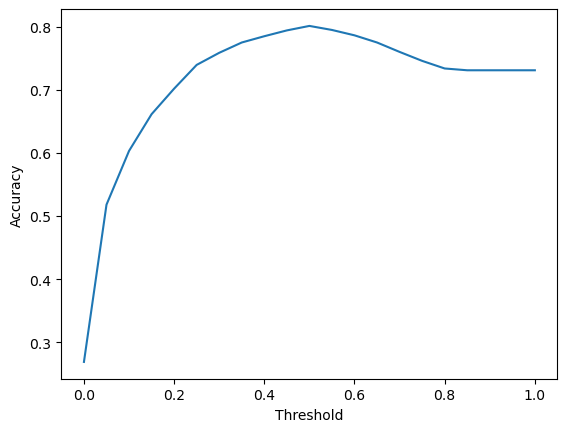

In [5]:
import matplotlib.pyplot as plt

plt.plot(thresholds, scores)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")

It turns out that a threshold of 0.5 indeed gives the highest accuracy. This is not always the case though.

If we look at the very right of the plot (threshold of 1), we seen an accuracy of about 73%. It means that if we predict no one to churn, we will be right in 73% of cases. This is not surprising, because this is also the non-churn rate:

In [6]:
(y_val==0).mean()

np.float64(0.7310149041873669)

On the other end of the plot, when we predict no one to churn, we are right in 27% of cases (the churn rate).

Since we have class imbalance (more samples not churning than churning, accuracy can be misleading). To address this we have other metrics like: confusion table, precision, recall.

## 4.3 [Confusion table](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/03-confusion-table.md)


A confusion table provides an overview of different types of errors made by our model. We saw that we could get a pretty good accuracy in our model by just predicting the majority class. This is because of class imbalance.

A confusion table will show:
- True Positive
- True Negative
- False Positive
- False Negative

Positive = Churn
Negative = No churn

We preferably want only True predictions.

In [19]:
TP = ((y_pred >= 0.5) & (y_val==1)).sum()
TN = ((y_pred < 0.5) & (y_val==0)).sum()
FP = ((y_pred >= 0.5) & (y_val==0)).sum()
FN = ((y_pred < 0.5) & (y_val==1)).sum()

In [20]:
print(TP, TN, FP, FN)

199 930 100 180


In [23]:
np.array([[TN, FP],[FN, TP]])

array([[930, 100],
       [180, 199]])

In [25]:
(np.array([[TN, FP],[FN, TP]]) / (TN + FP + FN + TP)).round(2)

array([[0.66, 0.07],
       [0.13, 0.14]])

## 4.4 [Precision and Recall](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/04-precision-recall.md)


## 4.5 [ROC Curves](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/05-roc.md)


## 4.6 [ROC AUC](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/06-auc.md)


## 4.7 [Cross-Validation](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/07-cross-validation.md)


## 4.8 [Summary](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/08-summary.md)


## 4.9 [Explore more](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/09-explore-more.md)


In [ ]:
import pandas as pd


def prepare_df():

    # read data
    df = pd.read_csv("data-week-3.csv")

    # normalize columns
    df.columns = (
        df.columns
        .str.replace(" ", "_")
        .str.lower()
    )

    # normalize data of type 'object'
    for col in df.select_dtypes(object).columns:
        df[col] = (
            df[col]
            .str.lower()
            .str.replace(" ", "_")
        )

    return (
        df
        .assign(
            partner=lambda df_: pd.to_numeric((df_.partner=="yes").astype(int), downcast="integer"),
            seniorcitizen=lambda df_: pd.to_numeric(df_.seniorcitizen, downcast="integer"),
            dependents=lambda df_: pd.to_numeric((df_.dependents=="yes").astype(int), downcast="integer"),
            phoneservice=lambda df_: pd.to_numeric((df_.phoneservice=="yes").astype(int), downcast="integer"),
            paperlessbilling=lambda df_: pd.to_numeric((df_.paperlessbilling=="yes").astype(int), downcast="integer"),
            tenure=lambda df_: pd.to_numeric(df_.tenure, downcast="integer"),
            monthlycharges=lambda df_: pd.to_numeric(df_.monthlycharges, downcast="float"),
            totalcharges=lambda df_: pd.to_numeric(df_.totalcharges.replace("_", "0"), errors="coerce", downcast="float"),
            churn=lambda df_: pd.to_numeric((df_.churn=="yes").astype(int), downcast="integer"),
        )
        .astype(
            {
                "customerid": "string",
                "gender": "category",
                "multiplelines": "category",
                "internetservice": "category",
                "onlinesecurity": "category",
                "onlinebackup": "category",
                "deviceprotection": "category",
                "techsupport": "category",
                "streamingtv": "category",
                "streamingmovies": "category",
                "contract": "category",
                "paymentmethod": "category",
            }
        )
    )

df = prepare_df()

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

dv = DictVectorizer(sparse=False)

y_full_train = df_full_train.churn.values
y_test = df_test.churn.values
y_train = df_train.churn.values
y_val = df_val.churn.values

dicts_train = df_train.drop(columns="churn").to_dict(orient="records")
dicts_val = df_val.drop(columns="churn").to_dict(orient="records")

dv.fit(dicts_train)
X_train = dv.transform(dicts_train)
X_val = dv.transform(dicts_val)

model = LogisticRegression(solver="liblinear")
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy_score(y_pred, y_val)

We find a validation accuracy score of about 80%. This mean that our model is right, 80% of the time. Is this good?

To answer this question, let's create a dummy model which always predicts that a customer won't churn. Before we create the model itself, let's think about the expected score in such a case. If we always predict a customer won't churn, we will be right in all the cases that there is no churn and wrong in the cases that there is churn:

In [ ]:
(y_val==0).mean() * 1 + y_val.mean() * 0 

np.float64(0.7310149041873669)

We would expect our model to be right 73% of the time. Now let's create the dummy model:

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier()

dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_val)

accuracy_score(y_pred, y_val)

0.7310149041873669

As expected we find that such a model yields a score of 73%. The added value of our logistic regression prediction therefore is 7%.

## 4.10 [Homework](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/homework.md)